Clean the Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
pd.set_option('display.float_format', '{:.2f}'.format)

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv('https://drive.google.com/uc?export=download&id=14ULvX0uOgftTB2s97uS8lIx1nHGQIB0P'), 
                 pd.read_csv('https://drive.google.com/uc?export=download&id=1r441wLr7gKGHGLyPpKauvCuUOU556S2f'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv('https://drive.google.com/uc?export=download&id=1wvsYl9hbRbZuIuoaLWCsW_kbcxCdocHz')
sample_submission = pd.read_csv('https://drive.google.com/uc?export=download&id=1kfJewnmhowpUo381oSn3XqsQ6Eto23XV')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

# Print dataframe shapes
print('train', train.shape)
print('val', val.shape)
print('test', test.shape)

train (47520, 41)
val (11880, 41)
test (14358, 40)


Handle Missing Values, convert types if necessary, extract features etc. 

In [3]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace them with the column mean.
    cols_with_zeros = ['construction_year', 'longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col] = X[col].fillna(X[col].mean())
        
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract year from date_recorded
    X['year_recorded'] = X['date_recorded'].dt.year
    
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    
    # for categoricals with missing values, fill with the category 'MISSING'
    categoricals = X.select_dtypes(exclude='number').columns
    for col in categoricals:
        X[col] = X[col].fillna('MISSING')
    
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

Select Features

In [4]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_fts = train.drop(columns=[target, 'id'])

# Get a list of the numeric features
num_fts = train_fts.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_fts.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
cat_fts = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = num_fts + cat_fts

In [5]:
num_fts

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'year_recorded']

In [6]:
cat_fts

['basin',
 'region',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

ENCODE AND SCALE

In [7]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Encoder: fit_transform on train, transform on val & test
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

# Scaler: fit_transform on encoded train, transform on encoded val & test
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Model: Fit on train, score on val, predict on test
model = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1)
model.fit(X_train_scaled, y_train)
print('Validation Accuracy', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
#submission.to_csv('submission-02.csv', index=False)

Validation Accuracy 0.7281144781144782


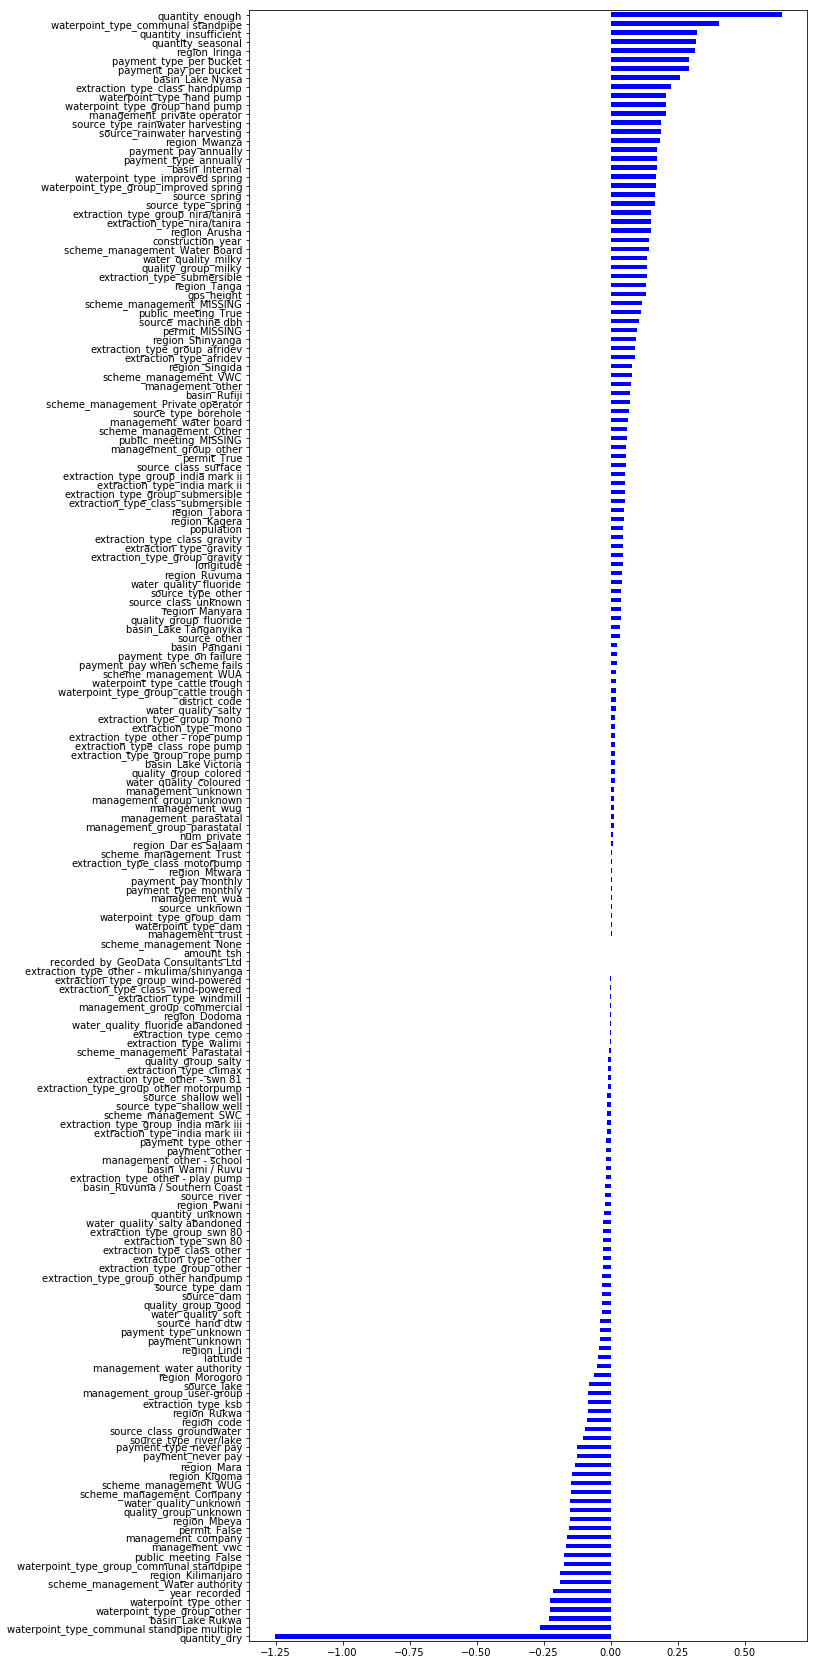

In [8]:
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='blue');

In [53]:
train_usage = X_train[['gps_height','amount_tsh']].copy()
val_usage = X_val[['gps_height','amount_tsh']].copy()

In [21]:
X_train_encoded.T

,43360,7263,2486,313,52726,8558,2559,54735,25763,44540,...,19682,38481,7096,36363,48006,9795,58170,17191,8192,49783
amount_tsh,0.00,500.00,25.00,0.00,0.00,0.00,20000.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,50.00,0.00,0.00,30.00,50.00
gps_height,0.00,2049.00,290.00,0.00,0.00,1295.00,1515.00,0.00,0.00,0.00,...,0.00,0.00,995.00,1227.00,0.00,489.00,0.00,599.00,426.00,501.00
longitude,33.54,34.67,38.24,30.72,35.39,31.21,36.70,36.29,32.88,33.01,...,33.95,33.59,35.48,37.64,32.91,38.27,33.93,39.26,39.35,37.56
latitude,-9.17,-9.31,-6.18,-1.29,-6.40,-8.43,-3.34,-5.18,-8.93,-3.12,...,-9.45,-8.93,-10.63,-3.24,-2.59,-5.45,-9.64,-10.77,-10.64,-6.89
num_private,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,0.00
region_code,12.00,11.00,6.00,18.00,1.00,15.00,2.00,1.00,12.00,19.00,...,12.00,12.00,10.00,3.00,19.00,4.00,12.00,90.00,90.00,5.00
district_code,4.00,4.00,1.00,1.00,6.00,2.00,2.00,1.00,6.00,7.00,...,3.00,2.00,2.00,1.00,3.00,6.00,3.00,33.00,33.00,6.00
population,0.00,175.00,2300.00,0.00,0.00,200.00,150.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,1300.00,0.00,1.00,320.00,90.00
construction_year,1996.83,2008.00,2010.00,1996.83,1996.83,1986.00,1995.00,1996.83,1996.83,1996.83,...,1996.83,1996.83,2003.00,2003.00,1996.83,2009.00,1996.83,2012.00,1988.00,1982.00
year_recorded,2011.00,2011.00,2011.00,2011.00,2011.00,2011.00,2013.00,2011.00,2011.00,2011.00,...,2011.00,2011.00,2013.00,2013.00,2011.00,2011.00,2011.00,2013.00,2013.00,2011.00


In [54]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_usage, y_train)
print('Decision Tree')
print('Train Accuracy', dt.score(train_usage, y_train))
print('Validation Accuracy', dt.score(val_usage, y_val))

Decision Tree
Train Accuracy 0.6702020202020202
Validation Accuracy 0.5572390572390572


In [51]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-02.csv', index=False)

In [52]:
submission.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
